# 0. Import libraries

In [120]:
!pip install pandas -q
!pip install numpy -q
!pip install geopy -q
!pip install matplotlib -q
!pip install seaborn -q
!pip install scikit-learn -q

In [121]:
import pandas as pd
import numpy as np
import geopy.distance
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from matplotlib import colors
from sklearn.preprocessing import LabelEncoder

# 1. Load data cleaning

- upload the dataset 
- check which entries are incorrect for some features and then fix or drop the entries (correctness)
- solve the NaN, for each case decide if we fix or drop (completeness)
- finally we can obtein the clean dataset, with which we can start to work and analyse it in step 2

In [122]:
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')
poi_df = pd.read_csv('data/poi.csv')

/tmp/ipykernel_16981/4245473066.py:3: DtypeWarning: Columns (7,9,11,13,17,18,19,22,23,24,25,26,28,29,30,32,33,34,35,36,37,38,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,74,77,80,82,83,84,85,86,87,90,91,92,95) have mixed types. Specify dtype option on import or set low_memory=False.
  poi_df = pd.read_csv('data/poi.csv')


In [123]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46312 entries, 0 to 46311
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   46312 non-null  int64  
 1   price                46312 non-null  int64  
 2   balcony              30869 non-null  object 
 3   conditions           45083 non-null  object 
 4   construction_year    32366 non-null  float64
 5   latitude             46299 non-null  float64
 6   longitude            46299 non-null  float64
 7   energy_efficiency    26409 non-null  float64
 8   expenses             30158 non-null  float64
 9   floor                44281 non-null  float64
 10  garden               14783 non-null  object 
 11  n_bathrooms          43896 non-null  float64
 12  elevator             28869 non-null  float64
 13  total_floors         27963 non-null  float64
 14  n_rooms              45959 non-null  float64
 15  proximity_to_center  46299 non-null 

In [124]:
train_df

,id,price,balcony,conditions,construction_year,latitude,longitude,energy_efficiency,expenses,floor,garden,n_bathrooms,elevator,total_floors,n_rooms,proximity_to_center,surface
0,10461,60000,True,Buono stato / Abitabile,1980.0,41.901300,12.700000,175.00,30.0,2.0,NaN,1.0,NaN,3.0,1.0,1.00000,35.0
1,51304,900000,NaN,Buono stato / Abitabile,NaN,41.907017,12.481311,NaN,NaN,3.0,NaN,1.0,1.0,NaN,3.0,1.00000,131.0
2,33032,33000,NaN,Buono stato / Abitabile,1960.0,41.976500,12.440500,204.20,30.0,4.0,NaN,1.0,NaN,4.0,1.0,1.00000,16.0
3,62281,166000,NaN,Ottimo / Ristrutturato,NaN,45.484800,12.198200,175.00,NaN,1.0,True,1.0,NaN,1.0,2.0,0.99205,100.0
4,45681,410000,True,Buono stato / Abitabile,NaN,45.424480,12.328622,65.91,NaN,3.0,NaN,2.0,1.0,NaN,3.0,1.00000,90.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46307,33085,329999,True,Buono stato / Abitabile,1929.0,41.923500,12.446100,175.00,35.0,3.0,NaN,1.0,NaN,4.0,3.0,1.00000,88.0
46308,17403,599000,True,Da ristrutturare,1920.0,41.916743,12.454925,NaN,170.0,6.0,NaN,2.0,1.0,NaN,5.0,1.00000,189.0
46309,33332,549000,True,Buono stato / Abitabile,NaN,45.454701,9.242711,NaN,NaN,NaN,NaN,2.0,1.0,NaN,3.0,1.00000,140.0
46310,63367,189000,True,Buono stato / Abitabile,1965.0,45.445605,9.245942,NaN,150.0,-1.0,True,1.0,1.0,NaN,3.0,1.00000,70.0


We start by making an anysis of the NaN

In [125]:
def NaN_analysis(df):
    # analysis1: percentage of NaN values in columns
    d = {'column': [], 'n_nan': [], 'percentage': []}
    for col in df.columns:
        n_nan = df[(df[col].isna()) | (df[col].isnull())].shape[0]
        d['column'].append(col)
        d['n_nan'].append(n_nan)
        d['percentage'].append((n_nan*100)/df.shape[0])
    analysis1 = pd.DataFrame(d).sort_values('percentage', ascending=False).reset_index(drop=True)
    # analysis2: number of NaN values in each row grouped by number of NaN values
    d = {'n_nan': [], 'n_rows': []}
    for n_nan in range(1, df.shape[1]+1):
        n_rows = df[df.isna().sum(axis=1) == n_nan].shape[0]
        d['n_nan'].append(n_nan)
        d['n_rows'].append(n_rows)
    analysis2 = pd.DataFrame(d).sort_values('n_nan', ascending=False).reset_index(drop=True)
    return analysis1, analysis2

In [126]:
analysis1, analysis2 = NaN_analysis(train_df)

In [127]:
analysis1

,column,n_nan,percentage
0,garden,31529,68.079547
1,energy_efficiency,19903,42.975903
2,total_floors,18349,39.620401
3,elevator,17443,37.664104
4,expenses,16154,34.880808
5,balcony,15443,33.345569
6,construction_year,13946,30.113146
7,n_bathrooms,2416,5.216790
8,floor,2031,4.385472
9,conditions,1229,2.653740


In [128]:
analysis2

,n_nan,n_rows
0,17,0
1,16,0
2,15,0
3,14,0
4,13,0
5,12,1
6,11,3
7,10,172
8,9,147
9,8,536


We can observe that the set of lines having at least one NaN in [lat, lon and proximity_to_center] is equal to the set of lines having NaN in both lat and lon and proximity_to_center (precisely the number of line is 13)
\
[lat, lon and proximity_to_center] are very important data and the rows that don't have these features are only 13 (in particular the percentage of NaN in the columns is very small, below the order of 0.03%) so we can drop the NaN for these 13 lines

In [129]:
query = (train_df['longitude'].isna()) & (train_df['latitude'].isna()) & (train_df['proximity_to_center'].isna())
train_df[query]

,id,price,balcony,conditions,construction_year,latitude,longitude,energy_efficiency,expenses,floor,garden,n_bathrooms,elevator,total_floors,n_rooms,proximity_to_center,surface
1579,2969,595000,True,Buono stato / Abitabile,1950.0,NaN,NaN,NaN,NaN,NaN,True,3.0,NaN,NaN,6.0,NaN,150.0
6385,70,420000,NaN,Buono stato / Abitabile,1920.0,NaN,NaN,NaN,150.0,-1.0,NaN,1.0,1.0,NaN,2.0,NaN,52.0
8973,62290,695000,True,Nuovo / Nuova costruzione,1970.0,NaN,NaN,NaN,370.0,-1.0,True,3.0,1.0,NaN,8.0,NaN,160.0
11902,37111,598000,NaN,Ottimo / Ristrutturato,NaN,NaN,NaN,NaN,NaN,2.0,NaN,1.0,NaN,NaN,5.0,NaN,110.0
19904,62762,600000,NaN,Ottimo / Ristrutturato,NaN,NaN,NaN,NaN,NaN,2.0,True,2.0,NaN,NaN,5.0,NaN,130.0
23430,38524,480000,True,Buono stato / Abitabile,NaN,NaN,NaN,NaN,150.0,-1.0,True,2.0,1.0,NaN,3.0,NaN,106.0
26431,41072,475000,NaN,Buono stato / Abitabile,NaN,NaN,NaN,NaN,NaN,-1.0,NaN,1.0,1.0,NaN,5.0,NaN,205.0
27836,30091,1000000,True,Da ristrutturare,1960.0,NaN,NaN,NaN,300.0,-1.0,NaN,2.0,1.0,NaN,6.0,NaN,180.0
30429,8259,185000,NaN,Buono stato / Abitabile,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1.0,NaN,NaN,5.0,NaN,80.0
34887,17966,1000000,True,Buono stato / Abitabile,NaN,NaN,NaN,NaN,NaN,2.0,True,2.0,NaN,NaN,9.0,NaN,147.0


In [130]:
train_df = train_df.dropna(subset=['longitude', 'latitude', 'proximity_to_center']).reset_index(drop=True)

In [131]:
def groupby_count_percentage(df, col):
    tmp = df[col].to_frame()
    tmp.fillna('NaN', inplace=True)
    tmp['count'] = 0
    tmp = tmp.groupby(col).count().reset_index().sort_values('count', ascending=False).reset_index(drop=True)
    tmp['percentage'] = (tmp['count']*100)/df.shape[0]
    return tmp

We can notice that for the features balcony and garden the NaN are actually 'False'

In [132]:
groupby_count_percentage(train_df, 'balcony')

,balcony,count,percentage
0,True,30861,66.655867
1,NaN,15438,33.344133


In [133]:
groupby_count_percentage(train_df, 'garden')

,garden,count,percentage
0,NaN,31522,68.083544
1,True,14777,31.916456


In [134]:
train_df['garden'] = train_df['garden'].fillna(False)
train_df['balcony'] = train_df['balcony'].fillna(False)

We encode garden, balcony and condition. In order to have for each feature only int or float as data, in this way we can plot graphs to better understand what to do with the NaN if drop or fix them


In [136]:
train_df['garden'] = train_df['garden'].apply(lambda x: 1 if x == True else 0)
train_df['balcony'] = train_df['balcony'].apply(lambda x: 1 if x == True else 0)

In [140]:
map_conditions = {}
index = 0
for value in train_df['conditions'].unique():
    if value not in map_conditions:
        map_conditions[value] = index
        index += 1
map_conditions

{'Buono stato / Abitabile': 0,
 'Ottimo / Ristrutturato': 1,
 'Da ristrutturare': 2,
 'Nuovo / Nuova costruzione': 3,
 nan: 4}

In [142]:
train_df['conditions'] = train_df['conditions'].apply(lambda x: map_conditions[x])
train_df['conditions'] = train_df['conditions'].apply(lambda x: np.nan if x == map_conditions[np.nan] else x)

For each column that has at keast a NaN as a data we the histogram distribution also in 2D

In [143]:
columns_wnan = []
for col in train_df.columns:
    if train_df[train_df[col].isna()].shape[0] > 0:
        columns_wnan.append(col)
columns_wnan

['conditions',
 'construction_year',
 'energy_efficiency',
 'expenses',
 'floor',
 'n_bathrooms',
 'elevator',
 'total_floors',
 'n_rooms',
 'surface']

In [146]:
def get_hist(df, feature, min_value=None, max_value=None, b=100):
    df = df.dropna(subset=[feature]).reset_index(drop=True)
    if min_value == None:
        min_value = df[feature].min()
    if max_value == None:
        max_value = df[feature].max()
    tmp = df[df[feature] >= min_value]
    tmp = tmp[tmp[feature] <= max_value]
    plt.hist(tmp.loc[:, feature], bins=b)
    plt.title('histogram distribution of {} (min_value: {}, max_value: {}, bins: {})'.format(feature, min_value, max_value, b))
    plt.show()
    plt.close()
    plt.hist2d(pd.Series(np.array([i for i in range(tmp.loc[:, feature].shape[0])])), tmp.loc[:, feature], bins=b, norm = colors.LogNorm())
    plt.title('2D histogram distribution of {} (min_value: {}, max_value: {}, bins: {})'.format(feature, min_value, max_value, b))
    plt.colorbar()
    plt.show()
    plt.close()
    return

conditions


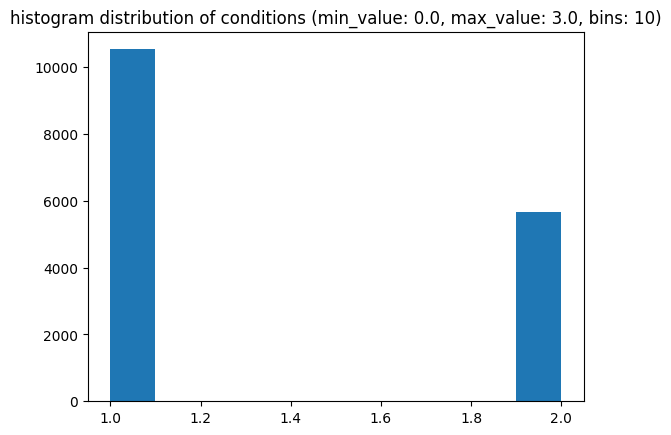

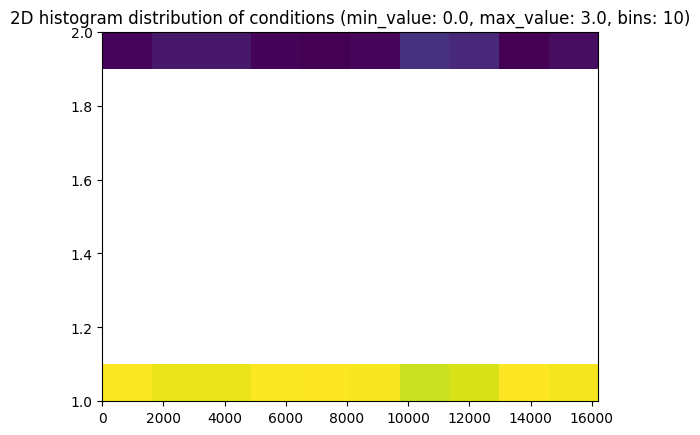

construction_year


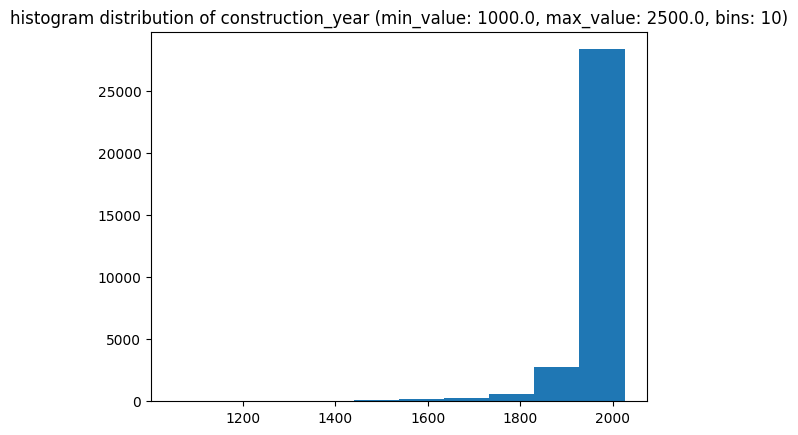

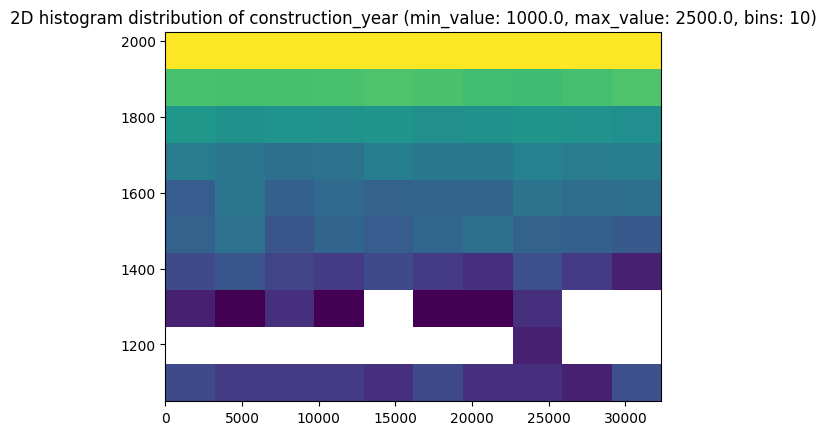

energy_efficiency


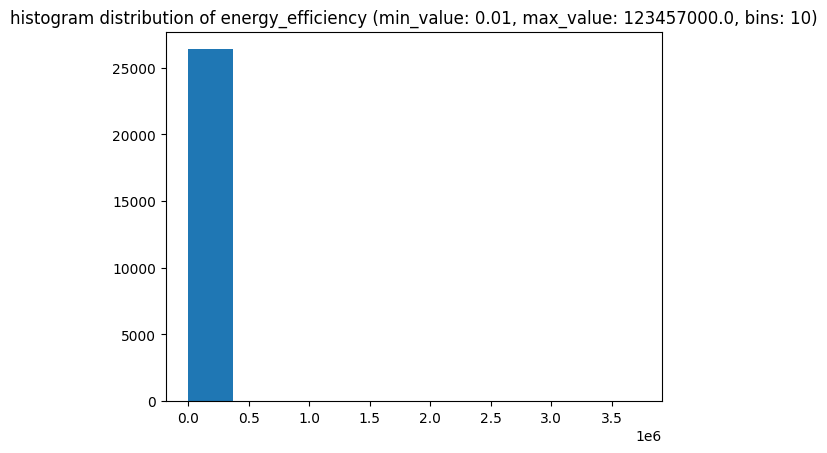

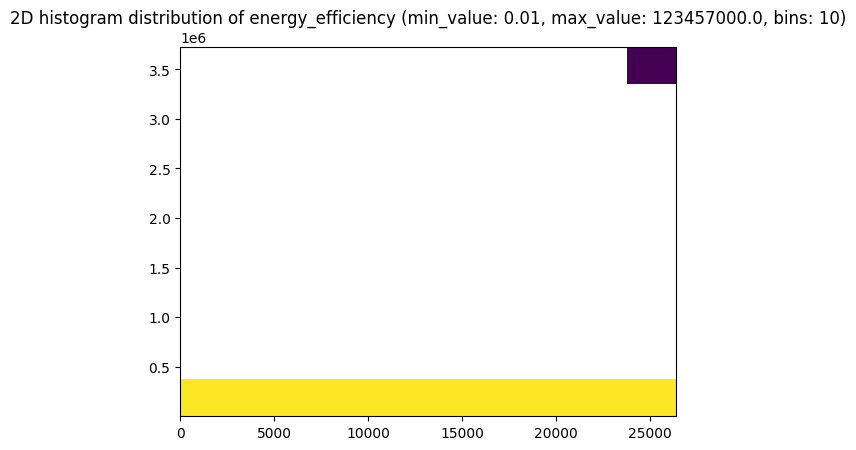

expenses


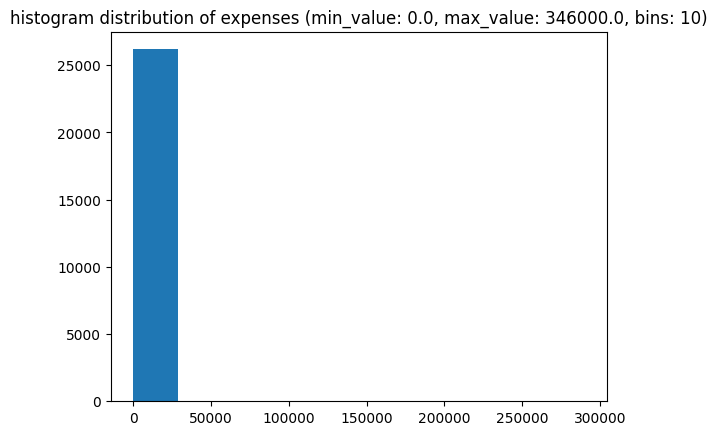

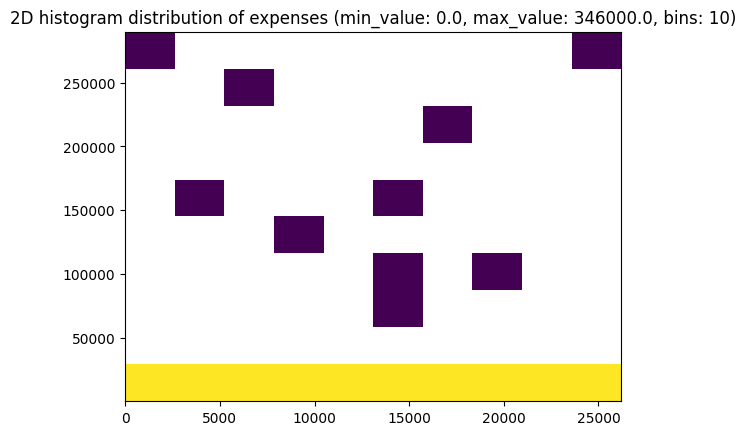

floor


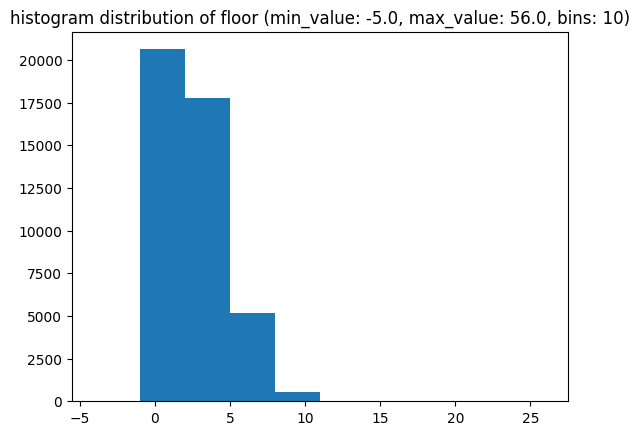

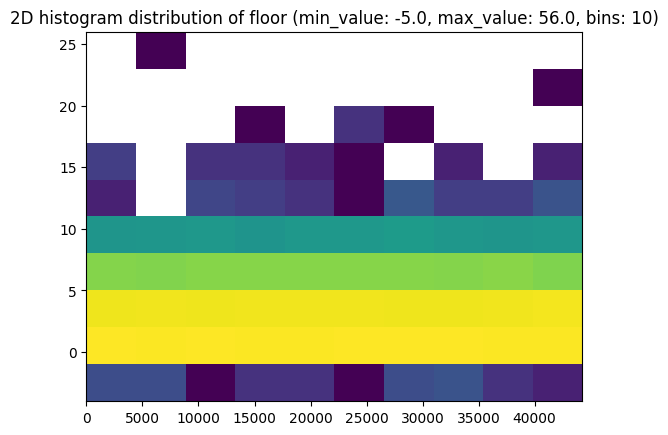

n_bathrooms


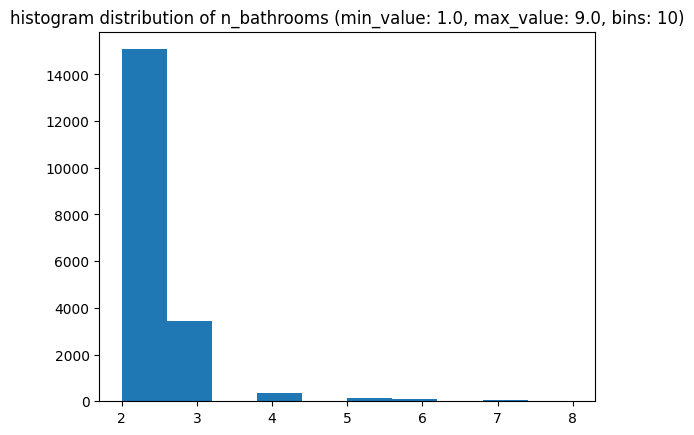

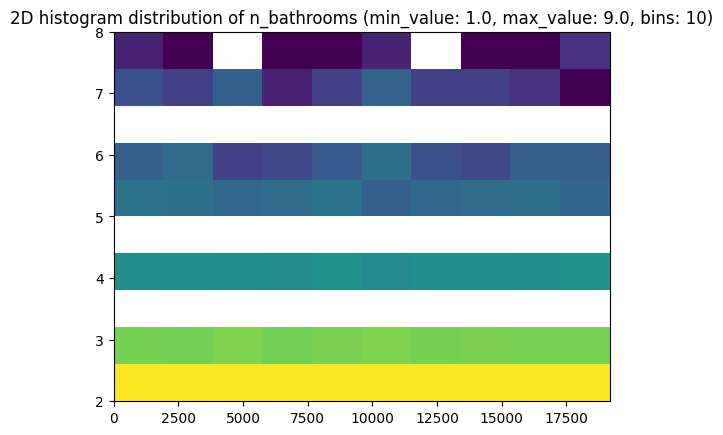

elevator


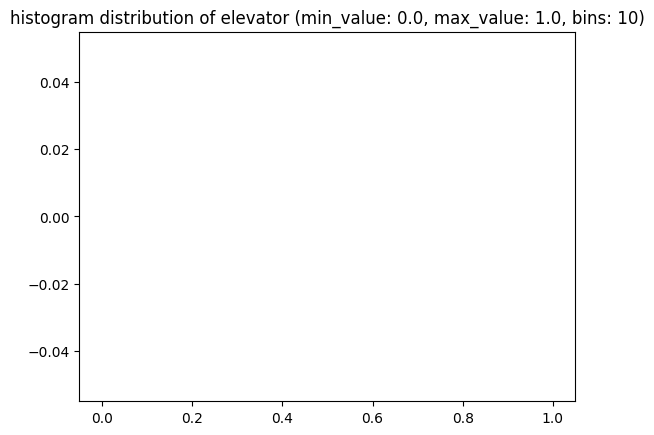

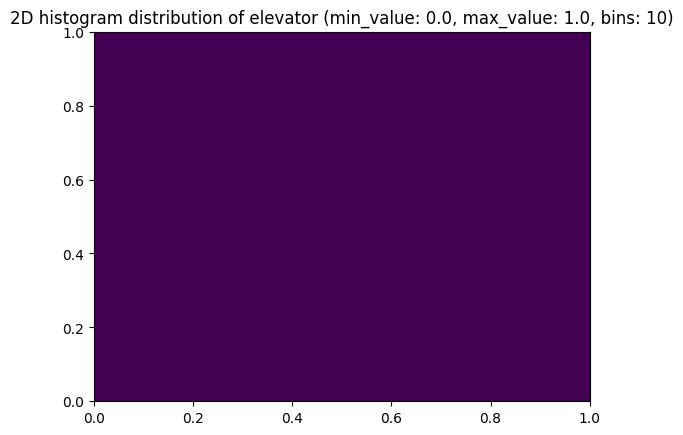

total_floors


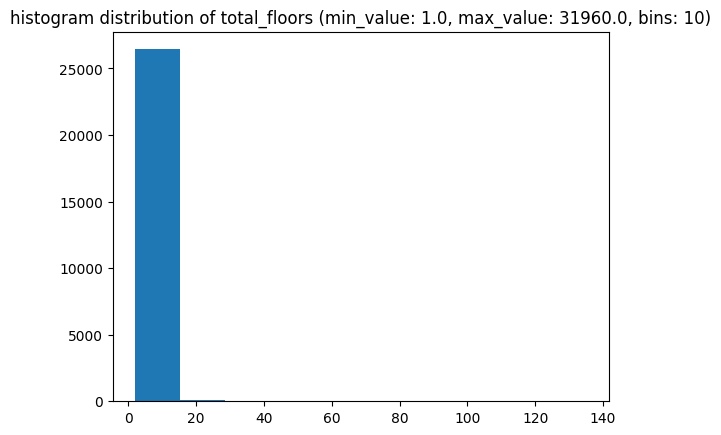

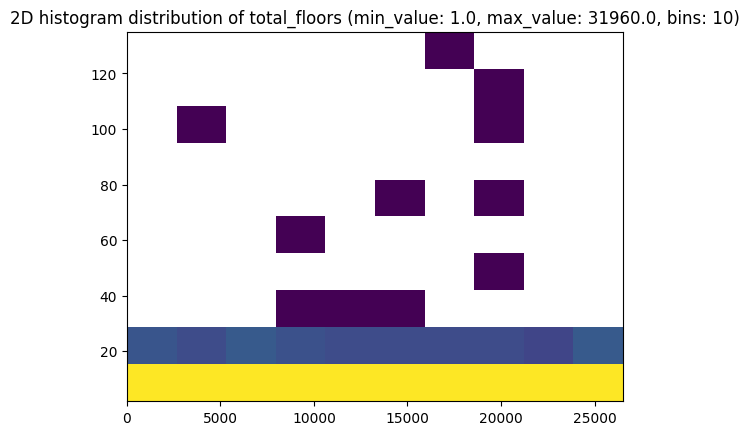

n_rooms


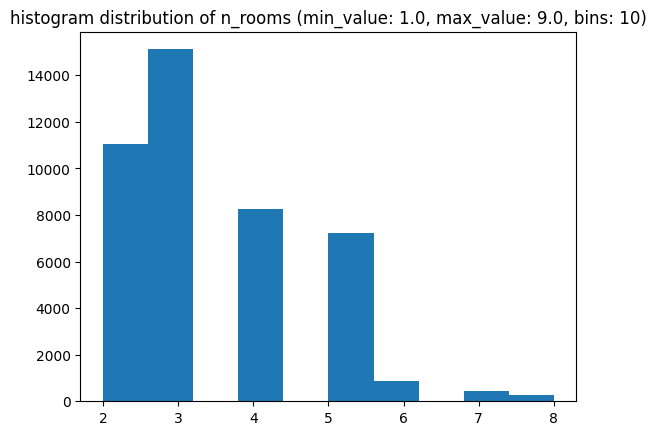

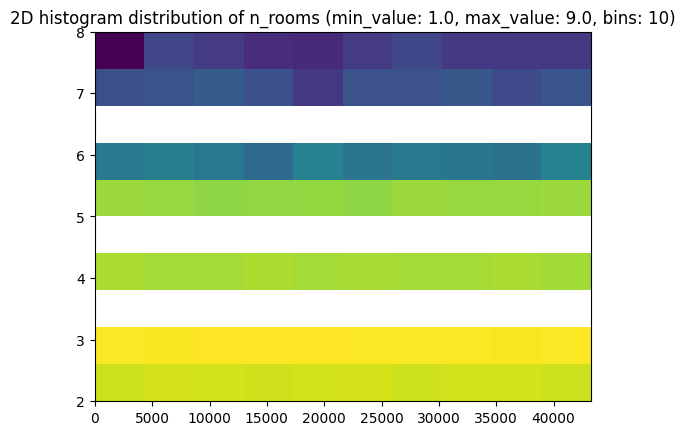

surface


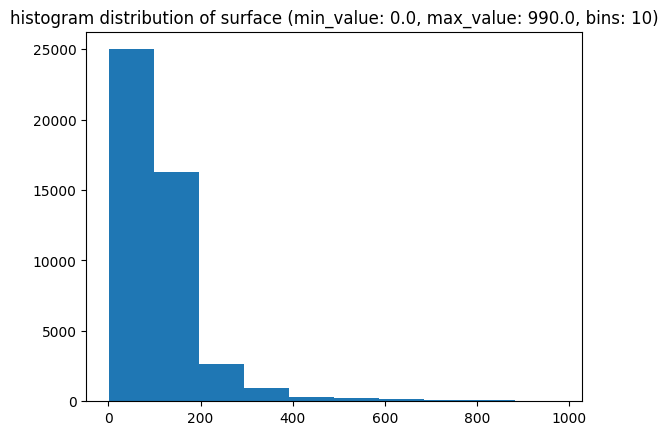

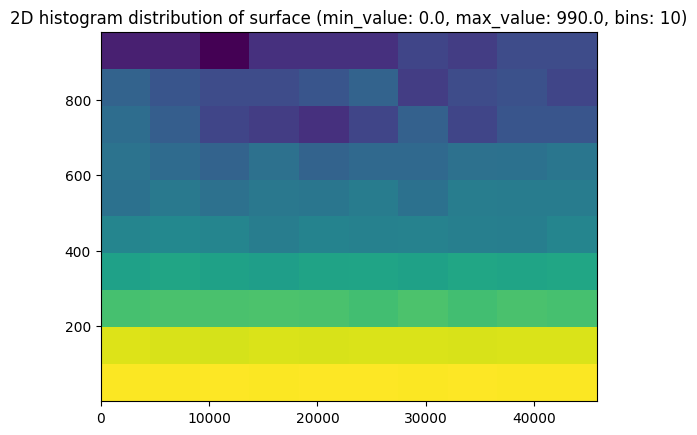

In [151]:
for col in columns_wnan:
    get_hist(train_df, col)

In [ ]:
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=2, weights="uniform")
train_df = pd.DataFrame(imputer.fit_transform(train_df), columns=train_df.columns)

In [2]:
'''
poi_df = poi_df[['lat', 'lon']]
lat, lon = train_df.iloc[0].latitude, train_df.iloc[0].longitude
lat = 52.406374
lon = 16.9251681
series = poi_df.apply(lambda x: geopy.distance.distance((lat, lon), (x['lat'], x['lon'])).km, axis=1)
series[series < 20]
series[series < 400]
def compute_distance_km(lat1, lon1, lat2, lon2):
    return geopy.distance.distance((lat1, lon1), (lat2, lon2)).km
lat1, lon1 = 1, 1
lat2, lon2 = 1, 1
compute_distance_km(lat1, lon1, lat2, lon2)
def foo(lat, lon, poi_df):
    series = poi_df.apply(lambda x: geopy.distance.distance((lat, lon), (x['lat'], x['lon'])).km, axis=1)
    series.sort_values()

    return
train_df['poi'] = train_df[['lat', 'lon']].apply(lambda x: foo(x['lat'], x['lon'], poi_df)) 
'''
pass

# 2. Dataset analysis

- plottare le distribuzioni
- rimuovere gli outliers (questo solo sul train set)

# 3. Feature importance analysis

- droppiamo le eventuali features che sono poco importanti per l'apprendimento 

# 4. Oversampling Undersampling

- nel caso di regression non serve undersampling
- quindi facciamo oversampling aumentando i samples sinteticamente con funzioni apposite (SMOTE)
- oppure tramite integrazione di nuovi samples non sintetici da internet

# 5. Training

- creare tutti i regressor possibili e trainarli

# 6. Testing (evaluation)
- performiamo i modelli trainati sul test set e quindi misuriamo le performance (MSE)

# 7. Tuning

- troviamo la combinazione di iperparametri migliori per il modello migliore che abbiamo fino ad ora ottenuto
- quindi accordiamo il modello migliore